In [414]:
import os
import time
import numpy as np
import tensorflow as tf
import tensorflow_text as tf_text
from data_utils import DataManager
from utils import print_bar, visualize_pi_weights
from par_model import PARTransformerXL
from par_model import create_lookahead_mask, positional_encoding

In [436]:
train_dm.ds_size.numpy()

2827

In [447]:
from pprint import pprint
pprint("Model parameters:\n",config)

AttributeError: 'dict' object has no attribute 'write'

## Load the wikitext2 train, validation and test data

In [416]:
config = {'tfrecords_directory':'data/wikitext2_bsz32_seqlen32_tfrecords_train',
                'sp_model_prefix': 'wiki2_12k'}
train_dm = DataManager.initialize_from_tfrecord(config)

config['tfrecords_directory'] = 'data/wikitext2_bsz32_seqlen32_tfrecords_valid'
valid_dm = DataManager.initialize_from_tfrecord(config)

config['tfrecords_directory'] = 'data/wikitext2_bsz32_seqlen32_tfrecords_test'
test_dm = DataManager.initialize_from_tfrecord(config)

Loading tokenizer from wiki2_12k.model...
Loading tfrecords from directory
Cause: could not parse the source code of <function load_tfrecord_ds_from_files.<locals>.<lambda> at 0x7fbbdb18e160>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function load_tfrecord_ds_from_files.<locals>.<lambda> at 0x7fbbdb18e160>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function load_tfrecord_ds_from_files.<locals>.<lambda> at 0x7fbbd9971940>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function load_tfrecord_ds_from_files.<locals>.<lambda> at 0x7fbbd9971940>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

## Initialize model architecture

In [417]:
train_dm.ds_size

<tf.Tensor: shape=(), dtype=int64, numpy=2827>

In [418]:
tf.keras.backend.clear_session()

config = {
    'd_model':64, 
    'num_heads':4, 
    'max_position':512, 
    'd_ffn':128,
    'num_layers':6, 
    'mem_len':32, 
    'vocab_size':12000,
    'dropout_rate':0.1, 
    'cutoffs':[250, 2500, 12000], 
    'proj_factor':2, 
    'proj_dims':None,
}

ds_size = train_dm.ds_size
max_position = config['max_position']
pos_enc = positional_encoding(max_position, config['d_model'])
lookahead_mask = create_lookahead_mask(max_position, max_position)
model = PARTransformerXL(**config)

In [419]:
train_ds = train_dm.get_inp_tar_pairs()
x, y = next(iter(train_ds))
model(x, None, labels=y, training=True)
model.summary()

Model: "par_transformer_xl"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  768000    
_________________________________________________________________
adaptive_softmax (AdaptiveSo multiple                  255250    
_________________________________________________________________
stochastic_block (Stochastic multiple                  37764     
_________________________________________________________________
stochastic_block_1 (Stochast multiple                  37764     
_________________________________________________________________
stochastic_block_2 (Stochast multiple                  37764     
_________________________________________________________________
stochastic_block_3 (Stochast multiple                  37764     
_________________________________________________________________
stochastic_block_4 (Stochast multiple           

### Create simulated annealing schedule for gumbel softmax tau. We use exponential decay.

In [420]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [421]:
# Define metrics
train_loss = tf.keras.metrics.Mean()
valid_loss = tf.keras.metrics.Mean()
train_perp = tf.keras.metrics.Mean()
valid_perp = tf.keras.metrics.Mean()

In [422]:
# Define tau schedule, plus must specify total number of global steps
EPOCHS = 3
tot_steps = int(EPOCHS*ds_size.numpy())

tau_is_trainable = False

tau = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2.0,
    decay_steps = tot_steps,
    decay_rate = 0.1
)

print(f"Epochs: {EPOCHS}. Total steps: {tot_steps}")

Epochs: 3. Total steps: 8481


In [448]:
# Set up training step and optimizer.

learning_rate = CustomSchedule(config['d_model'], 4000)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(inp, x_mems, labels, tau):
    with tf.GradientTape() as tape:
        loss, mems = model(x, x_mems, labels=labels, training=True, tau=tau)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_perp(tf.math.exp(loss))
    return mems

In [449]:
@tf.function
def evaluation_step(x, x_mems, labels, tau):
    loss, mems = model(x, x_mems=x_mems, labels=labels, tau=tau, training=False)
    perplexity = tf.math.exp(loss)
    valid_loss(loss)
    valid_perp(perplexity)
    return mems

def evaluation(dataset, tau):
    x_mems = None
    for x, lbl in dataset:
        x_mems = evaluation_step(x, x_mems, lbl, tau)

# @tf.function
# def evaluation(dataset, tau):
#     mems = None
#     for x, lbl in dataset:
#         loss, mems = model(x, x_mems=mems, labels=lbl, tau=tau, training=False)
#         perplexity = tf.math.exp(loss)
#         valid_loss(loss)
#         valid_perp(perplexity)

In [450]:
# Set up Checkpoints

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    try:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print ('Latest checkpoint restored!!')
    except:
        print("Model may have changed, could not restore checkpoint.")

In [451]:
# make tau untrainable
if not tau_is_trainable:
    for layer in model.layers:
        if hasattr(layer, 'tau'):
            layer.tau = tf.cast(tf.constant(1.), tf.float32)

In [452]:
# Set up TensorBoard

%load_ext tensorboard
train_log_dir = './logs' + '/train'
test_log_dir = './logs' + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [453]:
train_ds = train_dm.get_inp_tar_pairs().prefetch(tf.data.AUTOTUNE)
valid_ds = valid_dm.get_inp_tar_pairs().prefetch(tf.data.AUTOTUNE)

In [454]:
glob_step

In [455]:
%tensorboard --logdir ./logs
history={'loss':[], 'tau':[]}
glob_step = 0
num_batches = train_dm.ds_size.numpy()

for epoch in range(EPOCHS):
    
    print('-'*10,f' Epoch {epoch+1} ', '-'*10)
    start = time.time()
    train_loss.reset_states()
    mems = None
    for step, (inp, lbl) in enumerate(train_ds):
        
        mems = train_step(inp, mems, lbl, tau(glob_step))
        diff = (time.time()-start)/(step+1)
        printBar(step, num_batches, diff, train_loss.result().numpy())
                
        history['loss'].append(train_loss.result().numpy())
        history['tau'].append(tau(glob_step).numpy())
        
        with train_summary_writer.as_default():
            tf.summary.scalar('train_loss', train_loss.result(), step=glob_step)
            tf.summary.scalar('train_perp', train_perp.result(), step=glob_step)
            tf.summary.scalar('tau', tau(glob_step), step=glob_step)        
        glob_step += 1
     
    evaluation(valid_ds, tau(glob_step))
    with test_summary_writer.as_default():
        tf.summary.scalar('valid_loss', valid_loss.result(), step=glob_step)
        tf.summary.scalar('valid_perp', valid_perp.result(), step=glob_step)
    
    if (epoch + 1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

----------  Epoch 1  ----------


AttributeError: in user code:

    <ipython-input-448-f7b0885aefec>:9 train_step  *
        loss, mems = model(x, x_mems, labels=labels, training=True, tau=tau)
    /Users/jonathankernes/Documents/NLP/transformer-xl/PARtransformer/par_model.py:261 call  *
        x = self.embed(x)
    /Users/jonathankernes/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/jonathankernes/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/layers/embeddings.py:190 call
        dtype = K.dtype(inputs)
    /Users/jonathankernes/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/jonathankernes/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:1418 dtype
        return x.dtype.base_dtype.name
    /Users/jonathankernes/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:798 __getattribute__
        raise e
    /Users/jonathankernes/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:788 __getattribute__
        return super(OptimizerV2, self).__getattribute__(name)

    AttributeError: 'RMSprop' object has no attribute 'dtype'


In [457]:
tau(tf.Variable(0))

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

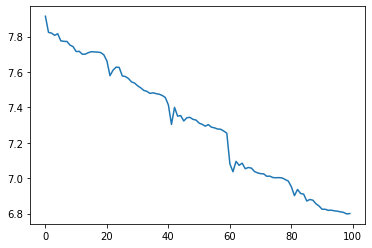

In [302]:
plt.plot(history['loss'])

In [152]:
for i in range(2,6):
    print(f"Layer {i-1}: {model.layers[i].pi.numpy()}")
    
for i in range(2,6):
    print(f"Layer {i-1}: {model.layers[i].tau.numpy()}")

Layer 1: [0.32119352 0.32047126 0.35673234]
Layer 2: [0.3197162  0.34020415 0.35368592]
Layer 3: [0.35318667 0.28377616 0.34028876]
Layer 4: [0.3391504  0.30977973 0.3718491 ]
Layer 1: 1.0
Layer 2: 1.0
Layer 3: 1.0
Layer 4: 1.0


In [ ]:
# Checkpointing and model saving

# Initializing a checkpoint manager
opt = tf.keras.optimizers.Adam(0.1)
dataset = toy_dataset()
iterator = iter(dataset)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=net, iterator=iterator)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=3)


# Restoring from a previous checkpoint
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print(f"Restored from {manager.latest_checkpoint})
else:
    print("Initializing from scratch.")

# Keep track of global step manually in the checkpoint
ckpt.step.assign_add(1)
if int(ckpt.step) % 10 == 0:
  save_path = manager.save()
  print(f"Saved checkpoint for step {int(ckpt.step)}: {save_path}")

<Figure size 144x432 with 0 Axes>

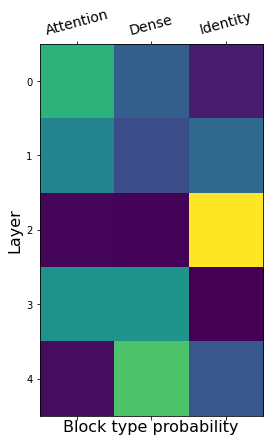

In [476]:
x = np.random.rand(5,3)
x /= np.sum(x, axis=1, keepdims=True)
fig = plt.figure(figsize=(2, 6))
# ax = fig.add_subplot(1, 1, 1)
# # plot the attention weights
# ax.matshow(x, cmap='viridis')
# fontdict = {'fontsize': 20}
# ax.set_xticks(range(x.shape[1]))
# ax.set_yticks(range(x.shape[0]))
# ax.set_xticklabels(['Attn', 'FFN', 'Id'], fontdict=fontdict, rotation=45)
# ax.set_yticklabels([i for i in range(x.shape[1])], fontdict=fontdict)
# ax.set_xlabel(f'Block type probability {1}')
# ax.set_ylabel(f'Layer')
# plot the attention weights
plt.matshow(x, cmap='viridis')
fontdict = {'fontsize': 20}
plt.xticks(range(x.shape[1]), ['Attention', 'Dense', 'Identity'], rotation=15, size=14)
plt.yticks(range(x.shape[0]), range(x.shape[0]))
plt.xlabel(f'Block type probability', size=16)
plt.ylabel(f'Layer', size=16)
plt.show()

In [481]:
@tf.function
def train_step(inp, x_mems, labels, tau):
    with tf.GradientTape() as tape:
        loss, mems = model(x, x_mems=x_mems, labels=labels, training=True, tau=tau)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_perp(tf.math.exp(loss))
    return mems

[None, None, None, None]
[None, None, 5, None]


In [508]:
@tf.function
def train_step(inp, mems, labels):
    loss, mems = model(inp, mems, labels, 2.0, True, None)
    return mems

In [509]:
train_ds = train_dm.get_inp_tar_pairs()

In [510]:
inp, lbl = next(iter(train_ds))

In [511]:
_, _ = model(inp, None, lbl, 2.0, True)

In [512]:
train_step.get_concrete_function(inp, None, lbl)

<ConcreteFunction train_step(inp, mems=None, labels) at 0x7FBB6D8579A0>

In [516]:
x = tf.Variable(0, dtype=tf.int64)
print(x)
x.assign_add(1)
print(x)

<tf.Variable 'Variable:0' shape=() dtype=int64, numpy=0>
<tf.Variable 'Variable:0' shape=() dtype=int64, numpy=1>


In [494]:
# train_step(inp, inp, labels=lbl, tau=2.0)
print(train_step.pretty_printed_concrete_signatures())

In [493]:
x, x_mems=None, labels=None, tau=None, training=None, pad_mask=None

Help on PARTransformerXL in module par_model object:

class PARTransformerXL(tensorflow.python.keras.engine.training.Model)
 |  PARTransformerXL(*args, **kwargs)
 |  
 |  `Model` groups layers into an object with training and inference features.
 |  
 |  Arguments:
 |      inputs: The input(s) of the model: a `keras.Input` object or list of
 |          `keras.Input` objects.
 |      outputs: The output(s) of the model. See Functional API example below.
 |      name: String, the name of the model.
 |  
 |  There are two ways to instantiate a `Model`:
 |  
 |  1 - With the "Functional API", where you start from `Input`,
 |  you chain layer calls to specify the model's forward pass,
 |  and finally you create your model from inputs and outputs:
 |  
 |  ```python
 |  import tensorflow as tf
 |  
 |  inputs = tf.keras.Input(shape=(3,))
 |  x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
 |  outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
 |  model = tf.keras.Mod

In [521]:
os.path.join('data', 'fun')

'data/fun'

In [ ]:
start = time.time()
for i in range(100):
    time.sleep(0.01)
    x = 5/np.sqrt(i+1)
    diff = (time.time()-start)/(i+1)
    printBar(i, 100, diff, x)